In [1]:
!pip install scikit-uplift catboost==0.22 --user

In [2]:
!pip install causalml

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [4]:
df = pd.read_csv('C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!PRACTICUM/Q4.MLiB/L4_data.csv', ',')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [5]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [7]:
# обратим внимание, что целевая переменная имеет неравномерное распределение 
# из 64000 клиентов покупку совершили только 9394

df["target"].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [8]:
# проверим наполнение атрибута treatment

df["treatment"].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [9]:
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
df["treatment"].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [10]:
df["history"].describe()

count    64000.000000
mean       242.085656
std        256.158608
min         29.990000
25%         64.660000
50%        158.110000
75%        325.657500
max       3345.930000
Name: history, dtype: float64

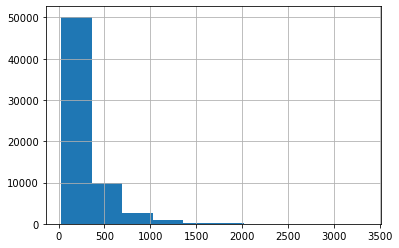

In [11]:
df["history"].hist()

In [12]:
#разброс значений в history очень большой, имеет смысл его нормализовать
df['history'] = (df['history'] - df['history'].min()) / (df['history'].max() - df['history'].min())

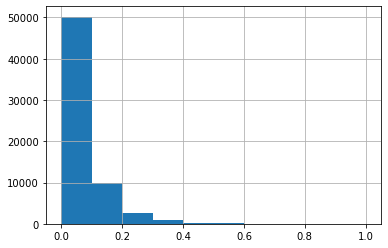

In [13]:
df["history"].hist()

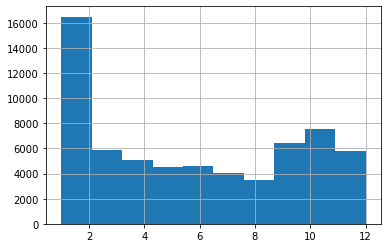

In [14]:
df["recency"].hist() # разброс не большой, данные распределены равномерно - не буду нормализовать

In [15]:
# можно избавиться от категорийных признаков - осталось два признака типа object 
# zip_code и channel - заменю на числовые представления
df.zip_code = df.zip_code.map({'Urban': 0, 'Surburban': 1, 'Rural': 2}) 
df.channel = df.channel.map({'Web': 0, 'Phone': 1, 'Multichannel': 2})

In [16]:
# также можно ввести дополнительный признак, определяющий класс клиента
# введение этого класса приводило к переобучению!

# indices = df.index
# df['target_class'] = 0           #lost causes
# df.loc[(df.treatment == 0) & (df.target == 1),'target_class'] = 1     #sure things
# df.loc[(df.treatment == 1) & (df.target == 0),'target_class'] = 2    #sleeping dogs
# df.loc[(df.treatment == 1) & (df.target == 1),'target_class'] = 3     #persuadables

In [17]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,0.033912,1,0,1,0,1,1,0
1,6,0.090198,1,1,2,1,0,0,0
2,7,0.045435,0,1,1,1,0,1,0
3,9,0.194768,1,0,2,1,0,1,0
4,2,0.004629,1,0,0,0,0,1,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  int64  
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  int64  
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.4 MB


### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [19]:
#собираем датафрэйм со свойствами

df_features = df.drop(['treatment', 'target'], axis=1)
df_features.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,0.033912,1,0,1,0,1
1,6,0.090198,1,1,2,1,0
2,7,0.045435,0,1,1,1,0


In [20]:
#собираем датафрэйм, где есть инфо было ли действие и какой результат

df_flag = df[['treatment', 'target']]
df_flag.head(3)

,treatment,target
0,1,0
1,0,0
2,1,0


In [21]:
# индексы набора действие/результат делим на две выборки

indices_train, indices_valid = train_test_split(df_flag.index, test_size=0.3, random_state=123)

In [22]:
# данные для обучения
X_train = df_features.loc[indices_train, :] # признаки о клиенте (в них остались только описания клиентов )
y_train = df_flag.loc[indices_train, 'target'] #целевой признак (те кто сделал правильное действие)
treat_train = df_flag.loc[indices_train, 'treatment']  #те кому написали смс с предложением

#данные для валидации
X_val = df_features.loc[indices_valid, :]
y_val = df_flag.loc[indices_valid, 'target']
treat_val =  df_flag.loc[indices_valid, 'treatment']

#весь набор целиком
X_train_full = df_features
y_train_full = df_flag.loc[:, 'target']
treat_train_full = df_flag.loc[:, 'treatment']

# наш категорийный признак
#cat_features = ['recency']

# словарь для записывания результатов
models_results = {
    'models': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

сделала ранее

### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [23]:
from sklearn.utils.validation import check_consistent_length
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

##### одна модель с признаком коммуникации (S learner)

uplift@10%: 0.1221, uplift@20%: 0.1013, uplift@30%: 0.08689197778102695


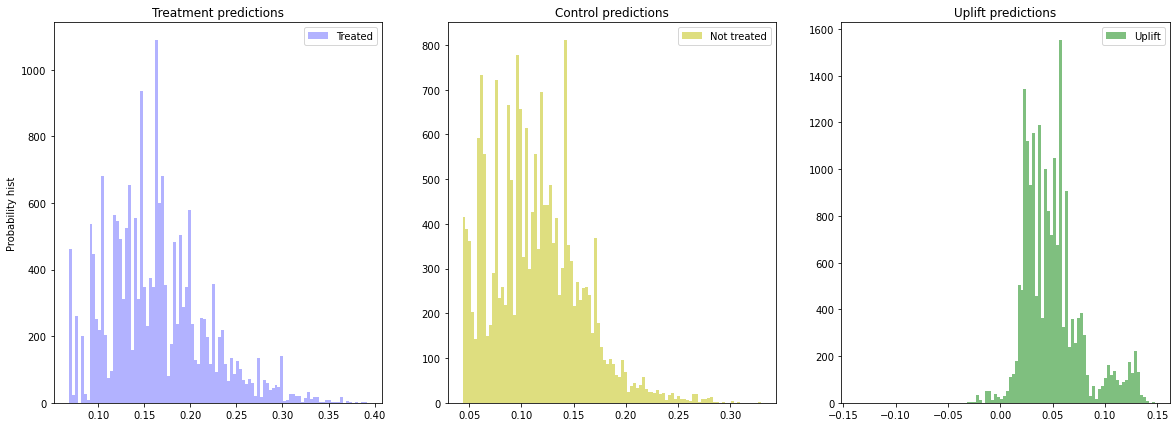

In [24]:
#N = 20000
sm = SoloModel(GradientBoostingClassifier(n_estimators=40, max_depth = 3, random_state = 1)) 
#GradientBoostingClassifier показала результат лучше, чем CatBoostClassifier

sm = sm.fit(X_train, y_train, treat_train)  

uplift_sm = sm.predict(X_val) 

# размер uplift на топ k процентах выборки
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@10%: {sm_score_10:.4f}, uplift@20%: {sm_score_20:.4f}, uplift@30%: {sm_score_30}')


models_results['models'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(sm_trmnt_preds , sm_ctrl_preds, bins=100);#ctrl_preds=

##### ??? что-то я запуталась, почему на графике предсказания от 0 до 0.4, а не от 0 до 1, как было на уроке...

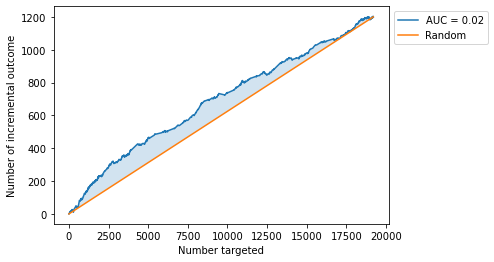

In [25]:
from sklift.viz import plot_uplift_curve


# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False); # perfect=True

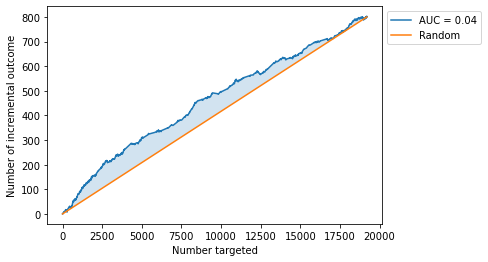

In [26]:
from sklift.viz import plot_qini_curve


# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_sm, treat_val, perfect=False);

In [27]:
from sklift.metrics import qini_auc_score


# коэффициент qini, или area under qini curve (AUQC)
auqc = qini_auc_score(y_val, uplift_sm, treat_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0371


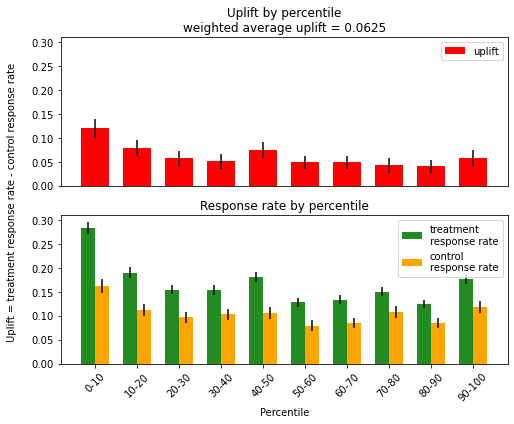

In [28]:
from sklift.viz import plot_uplift_by_percentile

# график uplift by percentile
plot_uplift_by_percentile(y_val, uplift_sm, treat_val, 
                          strategy='overall', kind='bar'); # line

In [29]:
from sklift.metrics import weighted_average_uplift

# с помощью значений в столбцах uplift и n_treatment рассчитаем усредненный uplift на всей выборке, 
# взвешенный на размер целевой группы — weighted average uplift
uplift_full_data = weighted_average_uplift(y_val, uplift_sm, 
                                            treat_val, bins=10) 
print(f"weighted average uplift on full data: {uplift_full_data:.4f}")

weighted average uplift on full data: 0.0622


##### модель с трансформацией таргета (трансформация классов п. 1.2) 

In [30]:
from sklift.models import ClassTransformation

In [31]:
ct = ClassTransformation(GradientBoostingClassifier(n_estimators=40, max_depth = 3, random_state = 1))

ct.fit(X_train, y_train, treatment=treat_train)

uplift_ct = ct.predict(X_val) 

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment = treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment = treat_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment = treat_val, strategy='by_group', k=0.3)
print(f'uplift@10%: {ct_score_10:.4f}, uplift@20%: {ct_score_20:.4f}, uplift@30%: {ct_score_30}')

models_results['models'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_20)

uplift@10%: 0.1143, uplift@20%: 0.1028, uplift@30%: 0.09263932091995467


##### вариант с двумя независимыми моделями

In [32]:
from sklift.models import TwoModels

uplift@10%: 0.1033, uplift@20%: 0.0790, uplift@30%: 0.0712577504496936


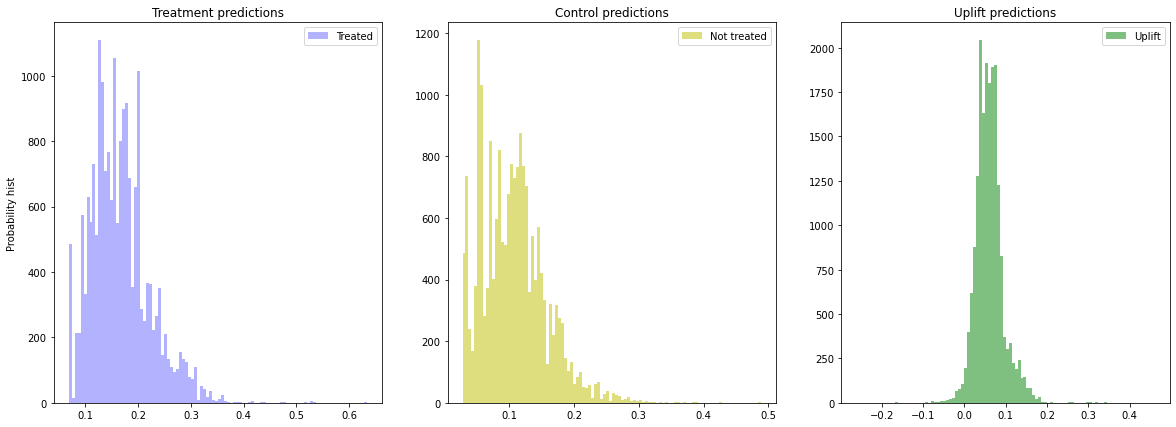

In [33]:
tm = TwoModels(estimator_trmnt = GradientBoostingClassifier(n_estimators=40, max_depth = 3, random_state = 1),
               estimator_ctrl =  GradientBoostingClassifier(n_estimators=40, max_depth = 3, random_state = 1),
               method='vanilla') 
#vanilla - независимые модели
#ddr_control или ddr_treatment - зависимые модели

tm.fit(X_train, y_train, treatment=treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment = treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment = treat_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment = treat_val, strategy='by_group', k=0.3)
print(f'uplift@10%: {tm_score_10:.4f}, uplift@20%: {tm_score_20:.4f}, uplift@30%: {tm_score_30}')

models_results['models'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [34]:
evaluate_models = pd.DataFrame(models_results)
evaluate_models

,models,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.122096,0.101264,0.101264
1,ClassTransformation,0.114282,0.102830,0.102830
2,TwoModels,0.103316,0.078987,0.078987


### 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [35]:
# X_train_tree = pd.concat([X_train.drop('gender', 1), 
#                           pd.get_dummies(X_train['gender'], prefix='gender')], 1)
# X_val_tree = pd.concat([X_val.drop('gender', 1), 
#                           pd.get_dummies(X_val['gender'], prefix='gender')], 1)
features = [col for col in X_train]

In [36]:
pip install causalml

In [39]:
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

In [ ]:
# при попытке построить дерево появляется ошибка GraphViz's executables not found

# from sklearn.tree import export_graphviz # не помогло

In [ ]:
# pip install graphviz # не помогло

In [ ]:
# conda install python-graphviz # и это тоже не помогло, как и дальнейшие танцы с бубном

In [ ]:
# import sys
# # sys.path #можно посмотреть что в PATH
# graphviz_path = 'C:/Users/sklod/anaconda3/Library/bin/graphviz'  #не забыть поправить ... и поставить двойные юниксовые слеши
# sys.path.insert(0, graphviz_path)
# #sys.path.remove(graphviz_path) - если что-то пошло не так и путь нужно удалить
# !dot -V  #проверить, что всё работает - должен вывести версию graphviz

In [ ]:
# pip install pydotplus

In [ ]:
# from graphviz import Graph

In [ ]:
%%time
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

### 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

### 9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево